In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from tensorflow.keras.models import Sequential, save_model
from tensorflow.keras.layers import LSTM, Dense

In [4]:
df=pd.read_csv("sunspots.csv")
df["Month"]=pd.to_datetime(df["Month"])
df.set_index('Month', inplace=True)
df

,Sunspots
Month,
1749-01-01,58.0
1749-02-01,62.6
1749-03-01,70.0
1749-04-01,55.7
1749-05-01,85.0
...,...
1983-08-01,71.8
1983-09-01,50.3
1983-10-01,55.8


In [5]:
df.dtypes

Sunspots    float64
dtype: object

In [19]:
df.isna().sum()

Sunspots    0
dtype: int64

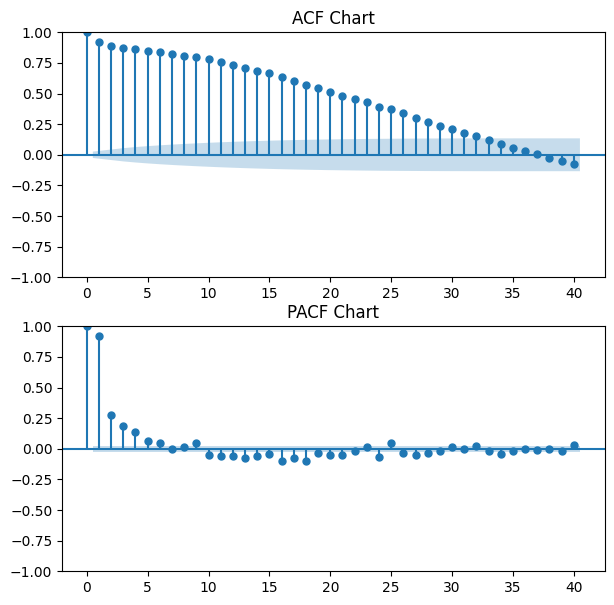

In [6]:
plt.figure(figsize = (7,7))
plt.subplot(2,1,1)
plot_acf(df['Sunspots'], lags = 40, ax = plt.gca(), title= "ACF Chart")
plt.subplot(2,1,2)
plot_pacf(df['Sunspots'], lags = 40, ax = plt.gca(), title= "PACF Chart")
plt.show()

In [21]:
def adf_test(dataset):
  dftest = adfuller(dataset, autolag = 'AIC')
  print("1. ADF : ",dftest[0])
  print("2. P-Value : ", dftest[1])
  print("3. Num Of Lags : ", dftest[2])
  print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
  print("5. Critical Values :")
  for key, val in dftest[4].items():
      print("\t",key, ": ", val)

In [22]:
adf_test(df["Sunspots"])

1. ADF :  -12.789531091616915
2. P-Value :  7.126154827020594e-24
3. Num Of Lags :  33
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 5604
5. Critical Values :
	 1% :  -3.4315174335991756
	 5% :  -2.862055891650023
	 10% :  -2.567044607646165


In [7]:
train_size = int(len(df) * 0.8)
train, test = df.iloc[:train_size], df.iloc[train_size:]

In [8]:
scaler = MinMaxScaler(feature_range=(0, 1))
train_date = train.index
test_date = test.index

In [9]:
train_values = train.values.reshape(-1, 1)
test_values = test.values.reshape(-1, 1)

In [10]:
train_scaled = scaler.fit_transform(train_values)
test_scaled = scaler.transform(test_values)

In [11]:
train_scaled = train_scaled.reshape(-1, len(train.columns))
test_scaled = test_scaled.reshape(-1, len(test.columns))

In [12]:
train_scaled_df = pd.DataFrame(train_scaled, columns=train.columns, index=train_date)
test_scaled_df = pd.DataFrame(test_scaled, columns=test.columns, index=test_date)

In [13]:
def create_sequences(data, sequence_length):
    sequences = []
    for i in range(len(data) - sequence_length + 1):
        seq = data[i:i + sequence_length]
        sequences.append(seq)
    return np.array(sequences)

In [14]:
sequence_length = 10
X_train = create_sequences(train_scaled_df.values, sequence_length)
X_test = create_sequences(test_scaled_df.values, sequence_length)

In [15]:
X_train, y_train = X_train[:, :-1], X_train[:, -1][:, -1]
X_test, y_test = X_test[:, :-1], X_test[:, -1][:, -1]

In [16]:
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [17]:
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=2)

Epoch 1/50


141/141 - 2s - loss: 0.0124 - val_loss: 0.0057 - 2s/epoch - 16ms/step
Epoch 2/50
141/141 - 0s - loss: 0.0046 - val_loss: 0.0053 - 456ms/epoch - 3ms/step
Epoch 3/50
141/141 - 0s - loss: 0.0044 - val_loss: 0.0050 - 440ms/epoch - 3ms/step
Epoch 4/50
141/141 - 0s - loss: 0.0042 - val_loss: 0.0049 - 450ms/epoch - 3ms/step
Epoch 5/50
141/141 - 0s - loss: 0.0042 - val_loss: 0.0047 - 468ms/epoch - 3ms/step
Epoch 6/50
141/141 - 0s - loss: 0.0041 - val_loss: 0.0046 - 462ms/epoch - 3ms/step
Epoch 7/50
141/141 - 0s - loss: 0.0040 - val_loss: 0.0046 - 472ms/epoch - 3ms/step
Epoch 8/50
141/141 - 1s - loss: 0.0040 - val_loss: 0.0045 - 509ms/epoch - 4ms/step
Epoch 9/50
141/141 - 1s - loss: 0.0040 - val_loss: 0.0045 - 578ms/epoch - 4ms/step
Epoch 10/50
141/141 - 1s - loss: 0.0039 - val_loss: 0.0045 - 606ms/epoch - 4ms/step
Epoch 11/50
141/141 - 0s - loss: 0.0039 - val_loss: 0.0046 - 467ms/epoch - 3ms/step
Epoch 12/50
141/141 - 0s - loss: 0.0039 - val_loss: 0.0045 - 471ms/epoch - 3ms/step
Epoch 13/50
14

In [18]:
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')

35/35 [==============================] - 0s 2ms/step
Mean Squared Error: 0.004300099200720011
Mean Absolute Error: 0.04731520221383375


In [20]:
model.save(r"models/sunspots_lstm_model.h5")

d:\Python\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
